<a href="https://colab.research.google.com/github/germanjke/cycleGAN_jeans_example/blob/master/fashioncycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle GAN


In [0]:
import numpy as np
import pandas as pd
import os
import zipfile

import argparse
import itertools

from torch.utils.data import DataLoader
from PIL import Image
import glob
from IPython.display import clear_output

import shutil 
from tqdm import tqdm
import PIL
from torchvision import transforms, models, datasets
import torchvision.transforms.functional as TF

import fastai
import fastai.vision

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy
import random

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q "/content/gdrive/My Drive/jeans.zip" -d jeans

Initilization, CUDA, 

In [0]:
def set_seed(seed=27):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    !nvidia-smi
else:
    print('Cuda is not available.')

Mon Jun 15 10:43:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Functions to work with images

In [0]:
def imshow(inp, title=None, plt_ax=None, default=False):
    if plt_ax is None:
        plt_ax = plt.gca()
    if title is None and type(inp) is tuple:
        inp, title = inp
    if type(inp) is tuple:
        inp = inp[0]
    if type(inp) is PIL.Image.Image:
        inp = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])(inp)
    if type(inp) is torch.Tensor and inp.is_cuda:
        inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    
    
def grid_show(data, max_images=9, random=False):
    imcount = min(len(data), max_images) if max_images > 0 else len(data)
    rows = int(np.ceil(imcount / 4))
    fig, axs = plt.subplots(ncols=4, nrows=rows, figsize=(15, rows * 5), sharey=True, sharex=True)
    axs = axs.flatten()
    idxs = range(imcount)
    if random:
        idxs = np.random.choice(len(data), size=imcount)
    for ax, i in enumerate(idxs):
        item = data[i]
        if hasattr(data, 'classes') and type(item) is tuple and len(item) == 2 and type(item[1]) is int:
            item = item[0], data.classes[item[1]]
        imshow(item, plt_ax=axs[ax])


In [0]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

Model

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [0]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)
        
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

Params

In [0]:
epoch = 0 # starting epoch
n_epochs = 200 #200 # number of epochs of training
batchSize = 6 # size of the batches
dataroot = './jeans/' # root directory of the dataset
lr = 0.0001 # initial learning rate
decay_epoch = 100 # epoch to start linearly decaying the learning rate to 0
size = 256 # size of the data crop (squared assumed)
input_nc = 3 # number of channels of input data
output_nc = 3 # number of channels of output data
n_cpu = 2 # number of cpu threads to use during batch generation

In [0]:
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

In [0]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Inputs & targets memory allocation
input_A = torch.zeros((batchSize, input_nc, size, size), requires_grad=False).to(device)
input_B = torch.zeros((batchSize, output_nc, size, size), requires_grad=False).to(device)
target_real = torch.ones(batchSize, requires_grad=False).to(device)
target_fake = torch.zeros(batchSize, requires_grad=False).to(device)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

data = ImageDataset(dataroot, transforms_=transforms_, unaligned=True)

mode_to_bpp = {'1':1, 'L':8, 'P':8, 'RGB':24, 'RGBA':32, 'CMYK':32, 'YCbCr':24, 'I':32, 'F':32}
for d in data.files_A:
    if mode_to_bpp[Image.open(d).mode] != 24:
        os.remove(d)
for d in data.files_B:
    if mode_to_bpp[Image.open(d).mode] != 24:
        os.remove(d)

dataloader = torch.utils.data.DataLoader(data, 
                        batch_size=batchSize, shuffle=True, num_workers=min(0, n_cpu, batchSize))

In [0]:
#load weights if have this 
netG_A2B.load_state_dict(torch.load('/content/gdrive/My Drive/netG_A2B_jeans195.pth'))
netG_B2A.load_state_dict(torch.load('/content/gdrive/My Drive/netG_B2A_jeans195.pth'))
netD_A.load_state_dict(torch.load('/content/gdrive/My Drive/netD_A_jeans195.pth'))
netD_B.load_state_dict(torch.load('/content/gdrive/My Drive/netD_B_jeans195.pth'))

<All keys matched successfully>

Training

In [0]:
for epoch in range(epoch, n_epochs):
    for i in range(len(dataloader)):
        try:
            for d in dataloader:
                batch = d
                break
        except FileNotFoundError:
            continue
        # Set model input
        real_A = input_A.copy_(batch['A'])
        real_B = input_B.copy_(batch['B'])
        
        if real_A.shape[1] != 3 or real_B.shape[1] != 3:
            continue

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A2 = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A2.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B2 = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B2.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        
        if i % 10 == 0:
            clear_output(wait=True)
            print('{}/{} epoch. {}/{} batch'.format(epoch, n_epochs, i, len(dataloader)))
            grid_show([real_A[0], fake_B[0].detach(), real_B[0], fake_A[0].detach()])
            plt.show()

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # Save the weights
    if epoch % 5 == 0:
        torch.save(netG_A2B.state_dict(), f'gdrive/My Drive/netG_A2B_jeans{str(epoch)}.pth')
        torch.save(netG_B2A.state_dict(), f'gdrive/My Drive/netG_B2A_jeans{str(epoch)}.pth')
        torch.save(netD_A.state_dict(), f'gdrive/My Drive/netD_A_jeans{str(epoch)}.pth')
        torch.save(netD_B.state_dict(), f'gdrive/My Drive/netD_B_jeans{str(epoch)}.pth')

13/200 epoch. 20/109 batch
Buffered data was truncated after reaching the output size limit.

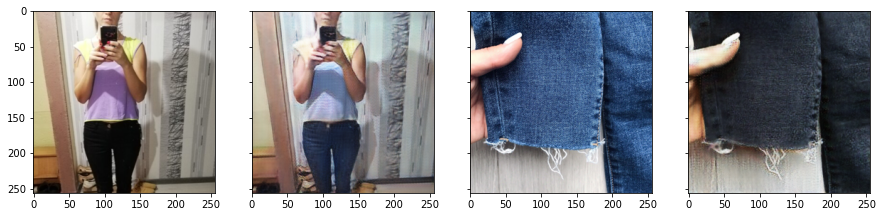

In [0]:
grid_show([real_A[3], fake_B[3].detach(), real_B[3], fake_A[3].detach()])